# [DRAFT] A box code for volumetric integration

The basic method I'm implementing here is from {cite:p}`ethridgeNewFastMultipoleAccelerated2001`.

Also:
{cite:p}`langstonFreespaceAdaptiveFMMBased2011` extended the method to 3D and {cite:p}`malhotraPVFMMParallelKernel2015b` made it distributed and fast.

{cite:p}`gholamiFFTFMMMultigrid2016a` demonstrates that an FMM method based on these ideas can be very competitive with other state of the art volumetric Poisson solver

### Next steps:

* Split into nearfield and far-field and run the full box code.
* Do some runtime benchmarks with the box code.
* Function extension by zero as default.

## Setup

In [1]:
from tectosaur2.nb_config import setup

setup()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

from tectosaur2 import gauss_rule
from tectosaur2.laplace2d import single_layer

In [3]:
x, y = sp.symbols("x, y")

In [4]:
# sym_soln = 2 + x + y + x ** 2 + y * sp.cos(6 * x) + x * sp.sin(6 * y)

In [5]:
gaussian_centers = np.array([[0.1, 0.1], [0, 0], [-0.15, 0.1]])
alpha = 250
ethridge_sym_soln = 0
for i in range(3):
    r2_i = (x - gaussian_centers[i, 0]) ** 2 + (y - gaussian_centers[i, 1]) ** 2
    ethridge_sym_soln += sp.exp(-alpha * r2_i)

In [6]:
ethridge_sym_laplacian = sp.diff(sp.diff(ethridge_sym_soln, x), x) + sp.diff(
    sp.diff(ethridge_sym_soln, y), y
)
ethridge_soln_fnc = sp.lambdify((x, y), ethridge_sym_soln, "numpy")
ethridge_laplacian_fnc = sp.lambdify((x, y), ethridge_sym_laplacian, "numpy")

## Singular quadrature, poor convergence.

In [11]:
def run(obs_pt, nq):
    q_vol, qw_vol = gauss_rule(nq)

    qx_vol, qy_vol = np.meshgrid(q_vol, q_vol)
    q2d_vol = np.array([qx_vol.flatten(), qy_vol.flatten()]).T.copy()
    q2d_vol_wts = (qw_vol[:, None] * qw_vol[None, :]).flatten()
    fxy = -ethridge_laplacian_fnc(q2d_vol[:, 0], q2d_vol[:, 1])

    u_particular = (
        (single_layer.kernel(obs_pt, q2d_vol)[:,0,:,0] * q2d_vol_wts[None, :])
        .dot(fxy)
        .reshape(obs_pt.shape[0])
    )
    return u_particular

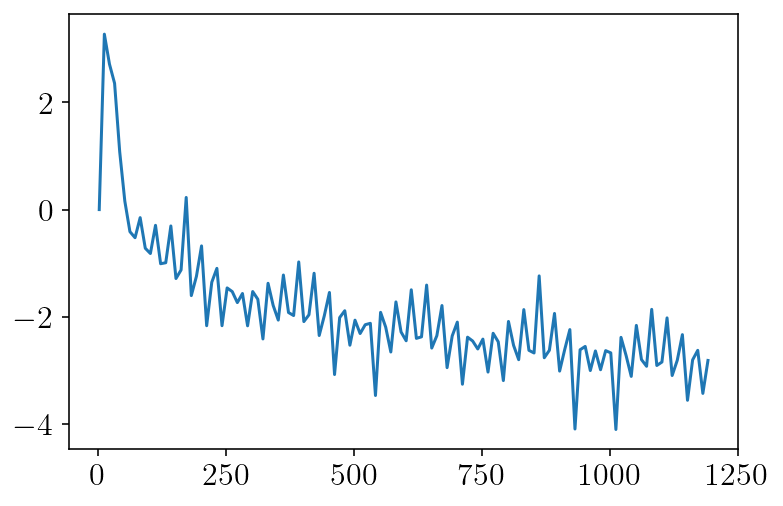

In [13]:
obs_pt = np.array([[-0.1, -0.1]])
correct = ethridge_soln_fnc(obs_pt[0, 0], obs_pt[0, 1])

steps = np.arange(2, 1200, 10)
ests = np.array([run(obs_pt, s) for s in steps])

difference = np.linalg.norm(ests - correct, axis=1) / np.linalg.norm(correct)

plt.plot(steps, np.log10(difference))
plt.show()

## Two-dimensional interpolation

In [14]:
import quadpy

def clencurt(n1):
    """Computes the Clenshaw Curtis quadrature nodes and weights"""
    C = quadpy.c1.clenshaw_curtis(n1)
    return (C.points, C.weights)


# TODO: is there a quadpy function that does tensor products?
def tensor_product(x, w):
    rect_x, rect_y = np.meshgrid(x, x)
    rect_pts = np.array([rect_x.flatten(), rect_y.flatten()]).T
    rect_w = np.outer(w, w).flatten()
    return rect_pts, rect_w


def clencurt_2d(n):
    return tensor_product(*clencurt(n))


def cheblob(n):
    """Computes the chebyshev lobatto."""
    pts = clencurt(n)[0]
    wts = (-1) ** np.arange(n).astype(np.float64)
    wts[0] *= 0.5
    wts[-1] *= 0.5
    return pts, wts  # tensor_product(pts, wts)

In [15]:
eps = np.finfo(float).eps


def barycentric_tensor_product(evalx, evaly, interp_pts, interp_wts, fnc_vals):
    """
    eval_pts is (N, 2)
    interp_pts is (Q,)
    interp_wts is (Q,)
    fnc_vals is (P, Q^2)
    """

    dx = evalx[:, None] - interp_pts
    dy = evaly[:, None] - interp_pts

    idx0, idx1 = np.where(dx == 0)
    dx[idx0, idx1] = eps
    idx0, idx1 = np.where(dy == 0)
    dy[idx0, idx1] = eps

    kernelX = interp_wts[None, :] / dx
    kernelY = interp_wts[None, :] / dy
    kernel = (kernelX[:, None, :] * kernelY[:, :, None]).reshape(
        (-1, fnc_vals.shape[1])
    )
    return (
        np.sum(kernel[None, :] * fnc_vals[:, None, :], axis=2)
        / np.sum(kernel, axis=1)[None, :]
    )

In [16]:
nobs = 100
zoomx = np.array([-1, 1])
zoomy = np.array([-1, 1])
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obsx_flat = obsx.flatten()
obsy_flat = obsy.flatten()
obs2d = np.array([obsx_flat, obsy_flat]).T.copy()

nI = 90
Ix, Iwts = cheblob(nI)
Ipts, Iwts2d = tensor_product(Ix, Iwts)

In [17]:
F = ethridge_laplacian_fnc(Ipts[:, 0], Ipts[:, 1])
F_interp = barycentric_tensor_product(obsx_flat, obsy_flat, Ix, Iwts, np.array([F]))
F_interp2d = F_interp.reshape(obsx.shape)
F_correct = ethridge_laplacian_fnc(obsx_flat, obsy_flat).reshape(obsx.shape)

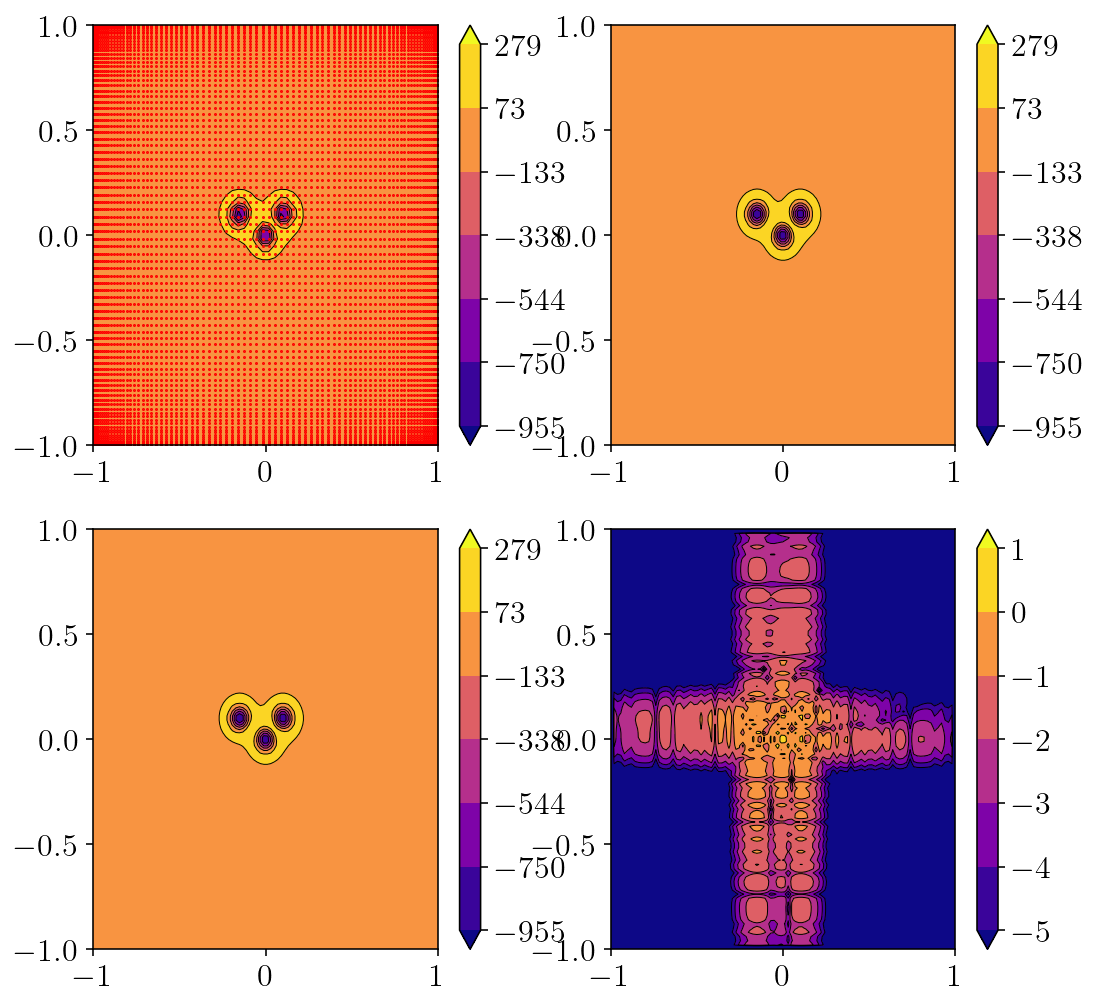

In [18]:
plt.figure(figsize=(8.5,8.5))
plt.subplot(2,2,1)
levels = np.linspace(np.min(F_correct), np.max(F_correct), 7)
cntf = plt.contourf(
    Ipts[:, 0].reshape((nI, nI)),
    Ipts[:, 1].reshape((nI, nI)),
    F.reshape((nI, nI)),
    levels=levels,
    extend="both",
)
plt.contour(
    Ipts[:, 0].reshape((nI, nI)),
    Ipts[:, 1].reshape((nI, nI)),
    F.reshape((nI, nI)),
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(Ipts[:,0], Ipts[:,1], 'ro', markersize=0.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(2,2,2)
levels = np.linspace(np.min(F_correct), np.max(F_correct), 7)
cntf = plt.contourf(obsx, obsy, F_interp2d, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    F_interp2d,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)


plt.subplot(2,2,3)
levels = np.linspace(np.min(F_correct), np.max(F_correct), 7)
cntf = plt.contourf(obsx, obsy, F_correct, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    F_correct,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(2, 2, 4)
levels = np.linspace(-5, 1, 7)
err = np.log10(np.abs(F_correct - F_interp2d)) / np.log10(np.mean(np.abs(F_interp2d)))
cntf = plt.contourf(obsx, obsy, err, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    err,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

## A box code

In [64]:
q1 = clencurt_2d(4)
q2 = clencurt_2d(7)
interp1 = cheblob(4)
interp2 = cheblob(7)

In [65]:
import matplotlib.patches as patches
from typing import List
from dataclasses import dataclass


@dataclass()
class TreeLevel:
    fhigh: np.ndarray
    centers: np.ndarray
    sizes: np.ndarray
    parents: np.ndarray
    is_leaf: np.ndarray

@dataclass()
class Tree:
    levels: List[TreeLevel]
    leaves: TreeLevel

def build_box_tree(f, start_centers, start_sizes, max_levels, tol):
    parents = np.zeros(start_centers.shape[0])
    centers = start_centers
    sizes = start_sizes
    levels = []
    for i in range(max_levels):
        box_low_pts = q1[0][None, :] * 0.5 * sizes[:, None, None] + centers[:, None, :]
        box_high_pts = q2[0][None, :] * 0.5 * sizes[:, None, None] + centers[:, None, :]
        box_quad_wts = q2[1][None, :] * 0.25 * sizes[:, None] ** 2

        f_high = f(
            box_high_pts[:, :, 0].ravel(), box_high_pts[:, :, 1].ravel()
        ).reshape((box_low_pts.shape[0], interp2[0].shape[0], interp2[0].shape[0]))

        # Because the Chebyshev Lobatto/Clenshaw Curtis points are nested, a 2N - 1 point
        # rule contains an N point rule inside it.
        f_low = f_high[:, ::2, ::2]

        f_high_flat = f_high.reshape((centers.shape[0], -1))
        f_low_flat = f_low.reshape((centers.shape[0], -1))

        # Interpolate to get an error estimate. Note that this error estimate will be
        # very conservative because it's estimating the error in the N low accuracy points
        # but we will end up using the 2N - 1 high accuracy points.
        f_high_interp = barycentric_tensor_product(
            q2[0][:, 0], q2[0][:, 1], interp1[0], interp1[1], f_low_flat
        )
        err = np.sqrt(np.sum((f_high_interp - f_high_flat) ** 2 * box_quad_wts, axis=1))

        # Don't refine if we're at the last level.
        if i == max_levels - 1:
            refine_boxes = np.array([], dtype=np.int64)
        else:
            refine_boxes = np.where(err > tol)[0]

        is_leaf = np.ones(centers.shape[0], dtype=bool)
        is_leaf[refine_boxes] = False

        levels.append(TreeLevel(f_high_flat, centers, sizes, parents, is_leaf))
        if refine_boxes.shape[0] == 0:
            break

        refine_centers = centers[refine_boxes]
        bump = sizes[refine_boxes] / 4

        parents = np.repeat(np.arange(centers.shape[0])[refine_boxes], 4)
        centers = np.concatenate(
            [
                refine_centers + np.array([bump, bump]).T,
                refine_centers + np.array([-bump, bump]).T,
                refine_centers + np.array([bump, -bump]).T,
                refine_centers + np.array([-bump, -bump]).T,
            ]
        )
        sizes = np.repeat(sizes[refine_boxes] / 2, 4, axis=0)

    return calculate_leaves(Tree(levels=levels, leaves=None))

def calculate_leaves(tree):
    leaves = []
    for i in range(len(tree.levels)):
        L = tree.levels[i]
        leaves.append((L.fhigh[L.is_leaf], L.centers[L.is_leaf], L.sizes[L.is_leaf], L.parents[L.is_leaf]))

    leaf_data = [
        np.concatenate([L[i] for L in leaves])
        for i in range(4)
    ]
    leaves = TreeLevel(*leaf_data, np.ones(leaf_data[0].shape[0], dtype=bool))
    return Tree(levels = tree.levels, leaves=leaves)

In [66]:
%%time
ethridge_tree = build_box_tree(ethridge_laplacian_fnc, np.array([[0, 0]]), np.array([1]), 10, 0.01)

CPU times: user 3.76 ms, sys: 1.14 ms, total: 4.9 ms
Wall time: 4.09 ms


In [67]:
ethridge_tree.leaves.centers.shape

(385, 2)

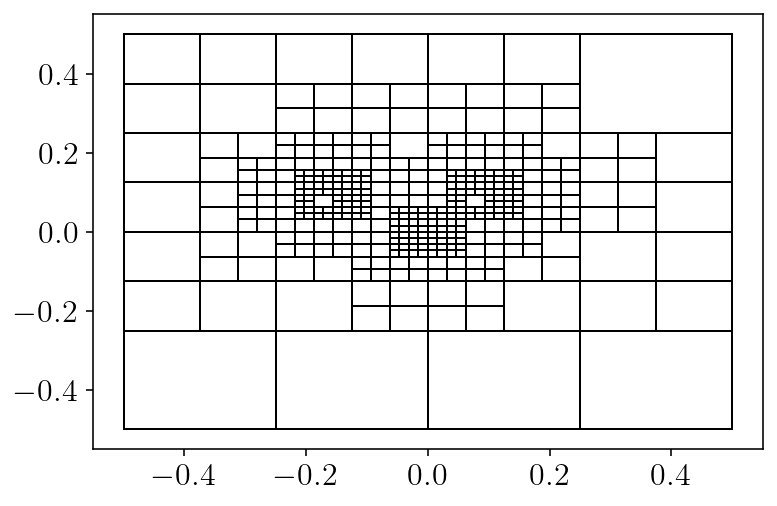

In [68]:
def plot_level(L):
    for i in range(L.centers.shape[0]):
        c = L.centers[i]
        s = L.sizes[i]
        plt.gca().add_patch(
            patches.Rectangle(
                (c[0] - s / 2, c[1] - s / 2),
                s,
                s,
                edgecolor="k",
                facecolor="none",
            )
        )
plot_level(ethridge_tree.leaves)
plt.xlim([-0.55, 0.55])
plt.ylim([-0.55, 0.55])
plt.show()

In [69]:
box_quad_wts = (
    q2[1][None, :] * 0.25 * ethridge_tree.leaves.sizes[:, None] ** 2
)
np.sum(box_quad_wts.ravel())

0.9999999999999999

In [70]:
test_tree = build_box_tree(lambda x, y: np.cos(10 * (x + y)), np.array([[0, 0]]), np.array([1]), 15, 0.000001)

box_quad_wts = (
    q2[1][None, :] * 0.25 * test_tree.leaves.sizes[:, None] ** 2
)

correct = 0.0367814305815291
est = np.sum(test_tree.leaves.fhigh.ravel() * box_quad_wts.ravel())
est, est - correct

(0.036781430581528794, -3.0531133177191805e-16)

## Volumetric Green's function integrals

In [71]:
def naive_eval(tree, obs_pts):
    box_high_pts = (
        q2[0][None, :] * 0.5 * tree.leaves.sizes[:, None, None] + tree.leaves.centers[:, None, :]
    )
    box_quad_wts = (
        q2[1][None, :] * 0.25 * tree.leaves.sizes[:, None] ** 2
    )

    G = fundamental_soln_matrix(obs_pts, box_high_pts.reshape((-1, 2)))[:, 0, :]
    out = (G * box_quad_wts.ravel()[None,:]).dot(tree.leaves.fhigh.ravel())
    return out

In [72]:
np.random.seed(2)
obs_test = (np.random.rand(1000, 2) - 0.5) * 0.2
est_rand = naive_eval(ethridge_tree, obs_test)
soln_rand = ethridge_soln_fnc(obs_test[:,0], obs_test[:,1])
err = np.max(np.abs(est_rand - soln_rand)) / np.max(np.abs(soln_rand))
print(err)

0.0041613921600802736


In [73]:
est_soln = naive_eval(ethridge_tree, obs2d).reshape(obsx.shape)
soln = ethridge_soln_fnc(obsx_flat, obsy_flat).reshape(obsx.shape)

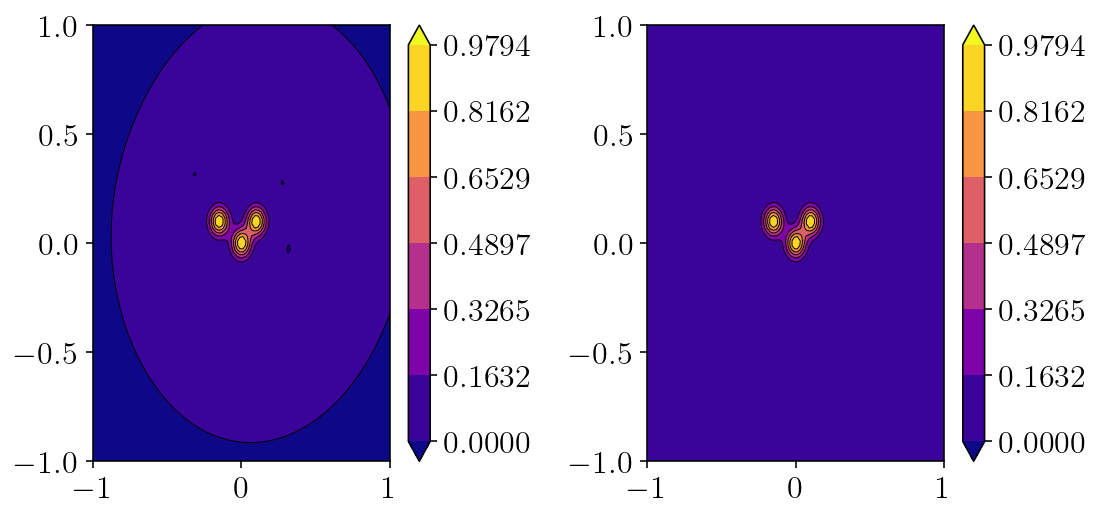

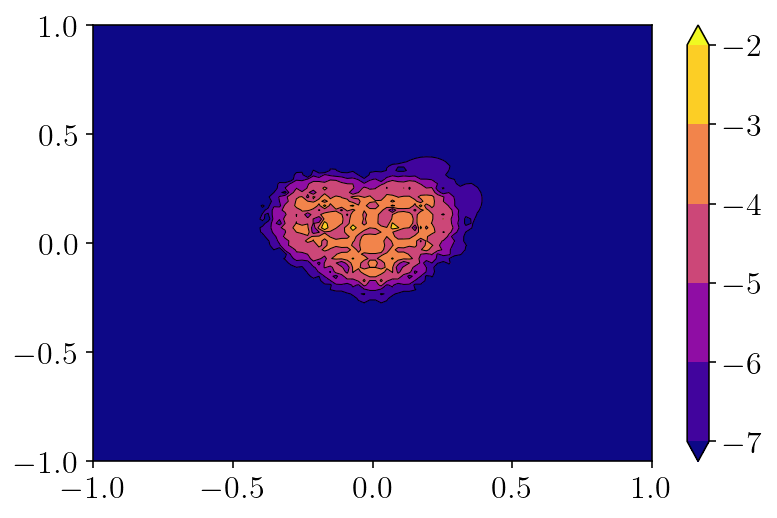

In [74]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
levels = np.linspace(np.min(soln), np.max(soln), 7)
cntf = plt.contourf(obsx, obsy, est_soln, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    est_soln,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1,2,2)
levels = np.linspace(np.min(soln), np.max(soln), 7)
cntf = plt.contourf(obsx, obsy, soln, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    soln,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()

levels = np.linspace(-7, -2, 6)
err = np.log10(np.abs(est_soln - soln))
cntf = plt.contourf(obsx, obsy, err, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    err,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()

## The 2:1 balance condition

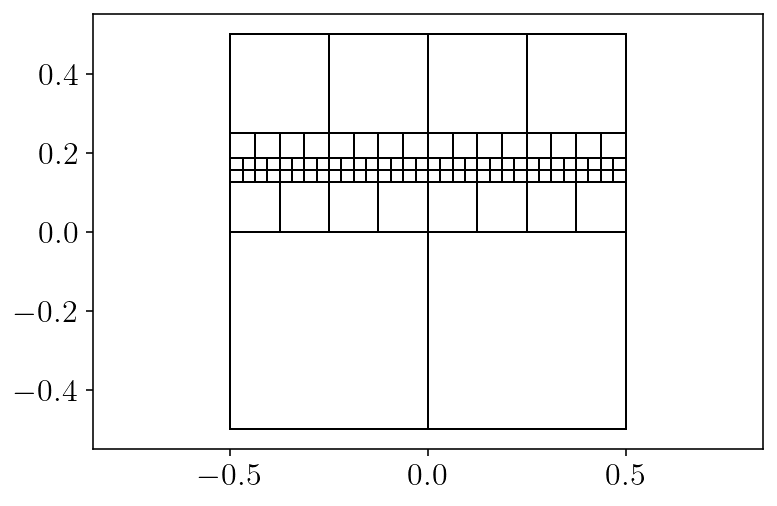

In [75]:
def test_f(x, y):
    return (y > 0.15) * 1.0
discontinuity_tree = build_box_tree(test_f, np.array([[0, 0]]), np.array([1]), 6, 0.001)
plot_level(discontinuity_tree.leaves)
plt.xlim([-0.55, 0.55])
plt.ylim([-0.55, 0.55])
plt.axis('equal')
plt.show()

In [76]:
def balance_21(tree, f, plot_progress=False):
    i = 0
    while i <= len(tree.levels) - 3:
        # We can skip splitting the level above because those cells all satisfy the
        # 2:1 criteria already
        did_refine = False
        for j in range(i + 2, len(tree.levels)):
            big_L = tree.levels[i]
            small_L = tree.levels[j]
            dx = small_L.centers[:,None,0] - big_L.centers[None,:,0]
            dy = small_L.centers[:,None,1] - big_L.centers[None,:,1]

            closex = np.abs(dx) <= 0.5 * (small_L.sizes[:,None] + big_L.sizes[None,:])
            closey = np.abs(dy) <= 0.5 * (small_L.sizes[:,None] + big_L.sizes[None,:])

            refine_boxes = np.any(closex & closey, axis=0) & big_L.is_leaf
            refine_centers = big_L.centers[refine_boxes]
            if refine_centers.shape[0] == 0:
                continue

            bump = big_L.sizes[refine_boxes] / 4

            parents = np.repeat(np.arange(big_L.centers.shape[0])[refine_boxes], 4)
            centers = np.concatenate(
                [
                    refine_centers + np.array([bump, bump]).T,
                    refine_centers + np.array([-bump, bump]).T,
                    refine_centers + np.array([bump, -bump]).T,
                    refine_centers + np.array([-bump, -bump]).T,
                ]
            )
            sizes = np.repeat(big_L.sizes[refine_boxes] / 2, 4, axis=0)

            box_high_pts = q2[0][None, :] * 0.5 * sizes[:, None, None] + centers[:, None, :]
            box_quad_wts = q2[1][None, :] * 0.25 * sizes[:, None] ** 2

            # TODO: either interpolate here or re-use the original function.
            f_high = f(
                box_high_pts[:, :, 0].ravel(), box_high_pts[:, :, 1].ravel()
            ).reshape((centers.shape[0], -1))
            # TODO: at the end, re-calculate leaves.

            child_L = tree.levels[i+1]
            big_L.is_leaf[refine_boxes] = False
            tree.levels[i+1] = TreeLevel(
                np.concatenate([child_L.fhigh, f_high]),
                np.concatenate([child_L.centers, centers]),
                np.concatenate([child_L.sizes, sizes]),
                np.concatenate([child_L.parents, parents]),
                np.concatenate([child_L.is_leaf, np.ones(centers.shape[0], dtype=bool)])
            )
            did_refine = True
            break

        if did_refine:
            if plot_progress:
                print(f'Splitting {refine_centers.shape[0]} boxes in level {i}')
                tree = calculate_leaves(tree)
                plot_level(tree.leaves)
                plt.xlim([-0.55, 0.55])
                plt.ylim([-0.55, 0.55])
                plt.axis('equal')
                plt.show()
            # If cells were refined in this level, then there may be cells in
            # the parent's level that now need to be refined, so we back up a step to
            # check.
            i -= 1
        else:
            # If no cells were refined, then proceed down the tree to the next level
            i += 1

In [77]:
balance_21(discontinuity_tree, test_f, plot_progress=False)

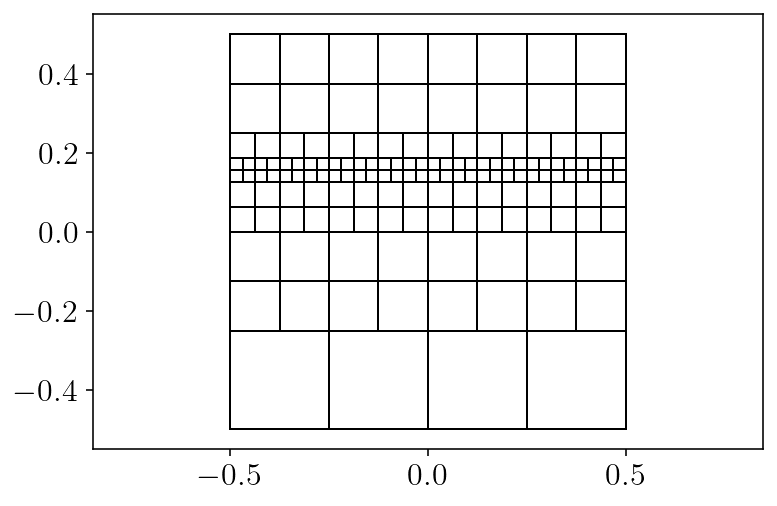

In [78]:
discontinuity_tree = calculate_leaves(discontinuity_tree)

plot_level(discontinuity_tree.leaves)
plt.xlim([-0.55, 0.55])
plt.ylim([-0.55, 0.55])
plt.axis('equal')
plt.show()

In [79]:
import copy
balanced_tree = copy.deepcopy(ethridge_tree)
balance_21(balanced_tree, ethridge_laplacian_fnc)
balanced_tree = calculate_leaves(balanced_tree)

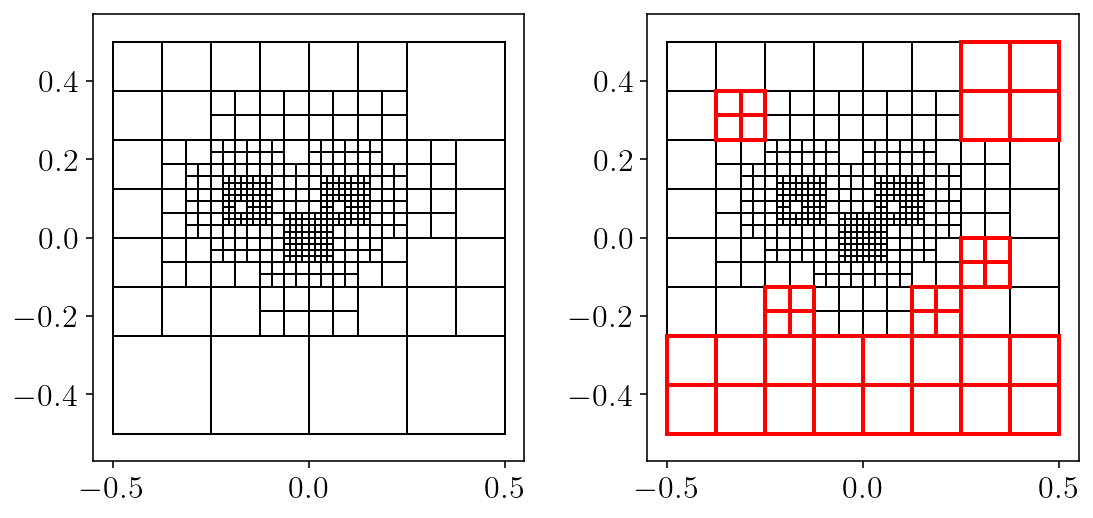

In [80]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plot_level(ethridge_tree.leaves)
plt.xlim([-0.55, 0.55])
plt.ylim([-0.55, 0.55])
plt.axis('equal')

plt.subplot(1, 2, 2)
plot_level(balanced_tree.leaves)
for i in range(balanced_tree.leaves.centers.shape[0]):
    c = balanced_tree.leaves.centers[i]
    s = balanced_tree.leaves.sizes[i]
    if np.any(np.linalg.norm(c[None,:] - ethridge_tree.leaves.centers, axis=1) == 0):
        continue
    plt.gca().add_patch(
        patches.Rectangle(
            (c[0] - s / 2, c[1] - s / 2),
            s,
            s,
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
    )
plt.xlim([-0.55, 0.55])
plt.ylim([-0.55, 0.55])
plt.axis('equal')
plt.tight_layout()
plt.show()

In [81]:
np.random.seed(2)
obs_test = (np.random.rand(1000, 2) - 0.5) * 0.2
est_rand = naive_eval(balanced_tree, obs_test)
soln_rand = ethridge_soln_fnc(obs_test[:,0], obs_test[:,1])
err = np.max(np.abs(est_rand - soln_rand)) / np.max(np.abs(soln_rand))
err

0.004161298220509971

In [82]:
est_soln_balanced = naive_eval(balanced_tree, obs2d).reshape(obsx.shape)

In [83]:
np.max(np.abs(est_soln - est_soln_balanced))

2.9824532052483144e-05

## Using precomputed near-field integrals

In [84]:
boxes = {
    # Type 0 (coincident)
    (1, 0, 0): (0, 1, 1, 0),
    # Type 1
    (1, 2, 2): (1, 1, 1, 0),
    (1, -2, 2): (1, -1, 1, 0),
    (1, -2, -2): (1, -1, -1, 0),
    (1, 2, -2): (1, 1, -1, 0),
    # Type 2
    (1, 2, 0): (2, 1, 1, 0),
    (1, 0, 2): (2, 1, 1, 1),
    (1, -2, 0): (2, -1, 1, 0),
    (1, 0, -2): (2, 1, -1, 1),
    # Type 3
    (2, 3, 3): (3, 1, 1, 0),
    (2, -3, 3): (3, -1, 1, 0),
    (2, -3, -3): (3, -1, -1, 0),
    (2, 3, -3): (3, 1, -1, 0),
    # Type 4
    (2, 1, 3): (4, 1, 1, 1),
    (2, -1, 3): (4, -1, 1, 1),
    (2, -3, 1): (4, -1, 1, 0),
    (2, -3, -1): (4, -1, -1, 0),
    (2, -1, -3): (4, -1, -1, 1),
    (2, 1, -3): (4, 1, -1, 1),
    (2, 3, -1): (4, 1, -1, 0),
    (2, 3, 1): (4, 1, 1, 0),
    # Type 5
    (0.5, 1.5, 1.5): (5, 1, 1, 0),
    (0.5, -1.5, 1.5): (5, -1, 1, 0),
    (0.5, -1.5, -1.5): (5, -1, -1, 0),
    (0.5, 1.5, -1.5): (5, 1, -1, 0),
    # Type 6
    (0.5, 0.5, 1.5): (6, 1, 1, 1),
    (0.5, -0.5, 1.5): (6, -1, 1, 1),
    (0.5, -1.5, 0.5): (6, -1, 1, 0),
    (0.5, -1.5, -0.5): (6, -1, -1, 0),
    (0.5, -0.5, -1.5): (6, -1, -1, 1),
    (0.5, 0.5, -1.5): (6, 1, -1, 1),
    (0.5, 1.5, -0.5): (6, 1, -1, 0),
    (0.5, 1.5, 0.5): (6, 1, 1, 0),
}

In [85]:
def nearfield_box(I, Fv, flipx, flipy, rotxy):
    # NOTE: The transpose is necessary simply because the definition of the basis functions here is the transpose of the definition in precompute. I should fix this!
    N = int(np.sqrt(Fv.shape[0]))
    Fv = Fv.reshape((N,N)).T

    n_rot = {
        (1, 1): 0,
        (1, -1): 1,
        (-1, -1): 2,
        (-1, 1): 3
    }[(flipx, flipy)]
    n_transpose = ((n_rot % 2) == 1) + rotxy

    # Rotate from input coordinates into position
    Fv = np.rot90(Fv, n_rot)
    if n_transpose % 2 == 1:
        Fv = Fv.T

    est = I.dot(Fv.ravel())

    # Reverse the transformation back to the original input space
    if n_transpose % 2 == 1:
        est = est.T
    est = np.rot90(est, -n_rot)
    return est

def scale_integral(I, basis_dot_F, src_s):
    scale_T = src_s / 2.0
    C = scale_T ** 2
    log_factor = C * (1 / (2 * np.pi)) * np.log(scale_T)
    return C * I + log_factor * basis_dot_F

In [86]:
basis_integrals, nearfield_integrals = np.load("data/nearfield_integrals.npy", allow_pickle=True)

In [87]:
nearfield_integrals.shape

(7, 7, 7, 49)

In [88]:
%%time
new_tree = build_box_tree(ethridge_laplacian_fnc, np.array([[0, 0]]), np.array([1]), 50, 10.0)
print(f'built tree with {new_tree.leaves.centers.shape[0] * q2[0].shape[0]} degrees of freedom, {new_tree.leaves.centers.shape[0]} leaves, and {len(new_tree.levels)} levels')

balance_21(new_tree, ethridge_laplacian_fnc)
new_tree = calculate_leaves(new_tree)
print(f'balanced tree has {new_tree.leaves.centers.shape[0]} leaves')

built tree with 1372 degrees of freedom, 28 leaves, and 4 levels
balanced tree has 28 leaves
CPU times: user 1.37 ms, sys: 786 µs, total: 2.16 ms
Wall time: 1.55 ms


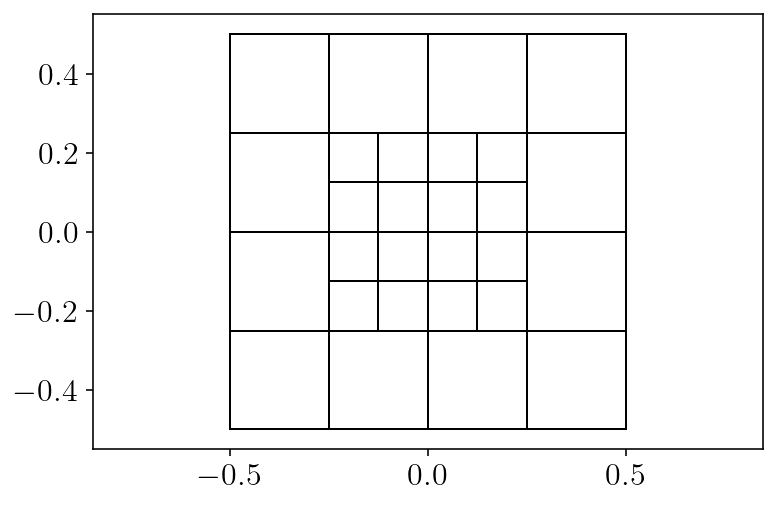

In [89]:
plot_level(new_tree.leaves)
plt.xlim([-0.55, 0.55])
plt.ylim([-0.55, 0.55])
plt.axis('equal')
plt.show()

In [90]:
%%time
box_high_pts = (
    q2[0][None, :] * 0.5 * new_tree.leaves.sizes[:, None, None] + new_tree.leaves.centers[:, None, :]
)
box_quad_wts = (
    q2[1][None, :] * 0.25 * new_tree.leaves.sizes[:, None] ** 2
)

obs_test = np.array([0.05,0.05])
sep = obs_test[None,:] - new_tree.leaves.centers
obs_i = np.where(np.all(np.abs(sep) <= new_tree.leaves.sizes[:, None] / 2, axis=1))[0][0]

obs_c = new_tree.leaves.centers[obs_i]
obs_s = new_tree.leaves.sizes[obs_i]
print(f'point contained in box {i}\n  with center: {obs_c}\n  and size: {obs_s}')
obs_pts = q2[0] * 0.5 * obs_s + obs_c
print(obs_c, obs_s)

src_cs = new_tree.leaves.centers
src_ss = new_tree.leaves.sizes
transformed_obs_center = np.round(2 * (obs_c[None,:] - src_cs) / src_ss[:,None], decimals=1)
transformed_obs_size = np.round(obs_s / src_ss, decimals=1)

point contained in box 411
  with center: [0.0625 0.0625]
  and size: 0.125
[0.0625 0.0625] 0.125
CPU times: user 621 µs, sys: 321 µs, total: 942 µs
Wall time: 688 µs


In [91]:
%%time
G = (
    fundamental_soln_matrix(obs_pts, box_high_pts.reshape((-1, 2)))[:, 0, :]
    * box_quad_wts.ravel()[None,:]
).reshape((q2[0].shape[0], src_cs.shape[0], q2[0].shape[0]))

CPU times: user 758 µs, sys: 664 µs, total: 1.42 ms
Wall time: 893 µs


/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_13101/3065275409.py:6: RuntimeWarning: divide by zero encountered in log
  G = C * np.log(r2)


In [92]:
%%time
src_terms = np.sum(G * new_tree.leaves.fhigh[None,:], axis=2)

CPU times: user 189 µs, sys: 51 µs, total: 240 µs
Wall time: 166 µs


In [93]:
%%time
nearfield = 0
add = 0
for j in range(src_cs.shape[0]):
    nearfield_info = boxes.get((transformed_obs_size[j], *transformed_obs_center[j]), None)
    if nearfield_info is not None:
        F = new_tree.leaves.fhigh[j]
        integral_type, flipx, flipy, rotxy = nearfield_info
        I = nearfield_box(nearfield_integrals[integral_type], F, flipx, flipy, rotxy)
        basis_I = basis_integrals.ravel().dot(F.ravel())
        scaled_I = scale_integral(I, basis_I, src_ss[j])

        src_terms[:, j] = scaled_I.ravel()
        nearfield += 1

CPU times: user 434 µs, sys: 129 µs, total: 563 µs
Wall time: 446 µs


In [94]:
add, correct_add

NameError: name 'correct_add' is not defined

In [95]:
%%time
result = np.sum(src_terms, axis=1) + add

print(f'there were {nearfield} nearfield cells')

correct_cell = ethridge_soln_fnc(obs_pts[:,0], obs_pts[:,1])
correct_pt = ethridge_soln_fnc(obs_test[0], obs_test[1])

obs_test_transformed = (obs_test - obs_c) / (obs_s * 0.5)
result_pt = barycentric_tensor_product(obs_test_transformed[:1], obs_test_transformed[1:], interp2[0], interp2[1], np.array([result]))[0,0]
result_naive = naive_eval(new_tree, np.array([obs_test]))[0]
print(correct_pt, result_pt)
print(f'precompute interpolate at {obs_test} error is: {correct_pt - result_pt:.3e}')
print(f'naive eval at {obs_test} error is: {correct_pt - result_naive:.3e}')

there were 9 nearfield cells
0.5730338945516394 0.5744516553258874
precompute interpolate at [0.05 0.05] error is: -1.418e-03
naive eval at [0.05 0.05] error is: -9.570e-03
CPU times: user 797 µs, sys: 214 µs, total: 1.01 ms
Wall time: 939 µs


## Check that tree integrates a simple function well.

#### Scratch

There are two sources of error here:
1. The integration error for the values of the integrals at the interpolation points.
2. The interpolation error for the values of the integrals away from the interpolation points.

Based on the previous demonstration, the first type of error is almost zero. The red points in the error figure above show the location of the interpolation points. You can see that the error oscillates around these points crossing zero at the points themselves.

In [ ]:
# obs_test_transformed = (obs_test - obs_c) / (obs_s * 0.5)

# Sprecompute = barycentric_tensor_product(obs_test_transformed[:1], obs_test_transformed[1:], interp2[0], interp2[1], np.array([result]))[0,0]

# correct = ethridge_soln_fnc(obs_test[0], obs_test[1])

# Snaive = naive_eval(balanced_tree, np.array([obs_test]))[0]

# Sprecompute, correct, np.linalg.norm(Sprecompute - correct) / np.linalg.norm(correct)

# Snaive, correct, np.linalg.norm(Snaive - correct) / np.linalg.norm(correct)

In [ ]:
# box_high_pts = (
#     q2[0][None, :] * 0.5 * new_tree.leaves.sizes[:, None, None] + new_tree.leaves.centers[:, None, :]
# )
# box_quad_wts = (
#     q2[1][None, :] * 0.25 * new_tree.leaves.sizes[:, None] ** 2
# )

# obs_test = np.array([0.01,0.01])
# for i in range(new_tree.leaves.centers.shape[0]):
#     c = new_tree.leaves.centers[i]
#     s = new_tree.leaves.sizes[i]
#     sep = obs_test - c
#     if np.all(np.abs(sep) <= s / 2):
#         print(f'point contained in box {i}\n  with center: {c}\n  and size: {s}')
#         obs_i = i

# result = np.zeros((new_tree.leaves.fhigh.shape[1]))
# obs_c = new_tree.leaves.centers[obs_i]
# obs_s = new_tree.leaves.sizes[obs_i]
# obs_pts = q2[0] * 0.5 * obs_s + obs_c
# print(obs_c, obs_s)

# nearfield = 0
# for j in range(new_tree.leaves.centers.shape[0]):
#     if j % 10000 == 0:
#         print(f'starting cell {j}')
#     src_c = new_tree.leaves.centers[j]
#     src_s = new_tree.leaves.sizes[j]
#     F = new_tree.leaves.fhigh[j]
#     transformed_obs_center = np.round(2 * (obs_c - src_c) / src_s, decimals=1)
#     transformed_obs_size = np.round(obs_s / src_s, decimals=1)

#     nearfield_info = boxes.get((transformed_obs_size, *transformed_obs_center), None)

#     if nearfield_info is not None:
#         integral_type, flipx, flipy, rotxy = nearfield_info
#         I = nearfield_box(nearfield_integrals[integral_type], F, flipx, flipy, rotxy)
#         basis_I = basis_integrals.ravel().dot(F.ravel())
#         scaled_I = scale_integral(I, basis_I, src_s)

#         result += scaled_I.ravel()
#         nearfield += 1
#     else:
#         sep = obs_c - src_c
#         assert(not np.all(np.abs(sep) <= 0.5 * (obs_s + src_s)))
#         G = (
#             fundamental_soln_matrix(obs_pts, box_high_pts[j])[:, 0, :]
#             * box_quad_wts[j].ravel()
#         )
#         result += G.dot(F)

# print(f'there were {nearfield} nearfield cells')

# correct_cell = ethridge_soln_fnc(obs_pts[:,0], obs_pts[:,1])
# correct_pt = ethridge_soln_fnc(obs_test[0], obs_test[1])

# obs_test_transformed = (obs_test - obs_c) / (obs_s * 0.5)
# result_pt = barycentric_tensor_product(obs_test_transformed[:1], obs_test_transformed[1:], interp2[0], interp2[1], np.array([result]))[0,0]

# result_naive_pt = naive_eval(new_tree, obs_test[None,:])[0]
# print('cell errors: ', correct_cell - result)
# print(f'precompute interpolate at {obs_test} error is: {correct_pt - result_pt:.3e}')
# print(f'naive compute at {obs_test} error is {correct_pt - result_naive_pt:.3e}')